# Rate of change and density of facilities and employment

In this notebook I calculate the rate of change of the number of geographic unit and employment in different sectors. Maybe I'll put the results on a chloropleth map. 

### Import libraries, read in Group A file as well as GIS file

In [441]:
import pandas as pd
import numpy as np
import math

def readFiles(input_filename):
    df=pd.read_csv(input_filename)
    df=df.drop("Unnamed: 0",axis=1)
    #Strip all leading whitespace in Area column
    df['Area'] = df['Area'].apply(lambda x: x.strip())
    return(df)

def spelling(df):
    df.loc[df['SA2_ascii']=="Putaruru Rural",'SA2_ascii']="Putararu Rural"
    df.loc[df['SA2_ascii']=="Putaruru",'SA2_ascii']="Putararu"
    df.loc[df['SA2_ascii']=="Whangaparaoa Central",'SA2_ascii']="Whangaparoa Central"
    return(df)


#Read in Group A file
groupA=readFiles("../CompleteSet_GroupA.csv")
#Subset only the records for 2000, 2005, 2010, 2015, 2020
y=[2000,2005,2010,2015,2020]
groupA=groupA.loc[groupA['Year'].isin(y),]
#Combine the transport and warehousing columns
transport=groupA[['I471_GeogUnits','I461_GeogUnits','I481_GeogUnits']]
transportEmp=groupA[['I471_EmpCo','I461_EmpCo','I481_EmpCo']]
groupA['Trans_GeogUnits']=transport.sum(axis='columns',skipna=True)
groupA['Trans_EmpCo']=transportEmp.sum(axis='columns',skipna=True)
storage=groupA[['I51_GeogUnits','I53_GeogUnits']]
storageEmp=groupA[['I51_EmpCo','I53_EmpCo']]
groupA['Storage_GeogUnits']=storage.sum(axis='columns',skipna=True)
groupA['Storage_EmpCo']=storageEmp.sum(axis='columns',skipna=True)
groupA=groupA.drop(['I51_GeogUnits','I53_GeogUnits','I471_GeogUnits','I461_GeogUnits','I481_GeogUnits','I51_EmpCo','I53_EmpCo','I471_EmpCo','I461_EmpCo','I481_EmpCo'],axis='columns')

#Delete totals row
groupA=groupA.loc[groupA['Area']!="Total NZ by Regional Council/Statistical Area"]

#Read in the previously converted csv file of multipolygons 
df_multipoly=pd.read_csv("./statistical-area-2-2020-generalised-LONLAT.csv")

#Correct spelling incongruencies
df_multipoly=spelling(df_multipoly)

##Remove the Oceanic regions
#oceanicList=[]
#for i in range(len(df_multipoly)):
 #   if "Oceanic" in df_multipoly.iloc[i,1]:
 #       oceanicList.append(i)
        

#df_multipoly=df_multipoly.drop(oceanicList)

#Read in region areas
df_multipoly_region=pd.read_csv("./region-2020-generalised-LONLAT.csv")

In [442]:
# Add land_area to the areas in Group A

groupA['landArea']=np.nan

for i in range(len(groupA)):
    if (groupA.iloc[i,7]!="NewZealand") & (groupA.iloc[i,0]!="Ross Dependency"):
        if(groupA.iloc[i,7]=="NewZealand"):
            groupA.iloc[i,13]=df_multipoly_region.loc[df_multipoly_region['SA2_ascii']==groupA.iloc[i,0],'Land_area']
        else:
            groupA.iloc[i,13]=df_multipoly.loc[df_multipoly['SA2_ascii']==groupA.iloc[i,0],'Land_area']
              

#Make all nans zero
groupA.fillna(0,inplace=True)


In [443]:
groupA['TotInd_Dens']=np.nan #14
groupA['F_Dens']=np.nan #15
groupA['G_Dens']=np.nan #16
groupA['Trans_Dens']=np.nan #17
groupA['Stor_Dens']=np.nan #18
groupA['TotInd_EmpDensFac']=np.nan #19
groupA['F_EmpDensFac']=np.nan #20
groupA['G_EmpDensFac']=np.nan #21
groupA['Trans_EmpDensFac']=np.nan #22
groupA['Stor_EmpDensFac']=np.nan #23


for i in range(len(groupA)):
    if groupA.iloc[i,0]!="Ross Dependency":
        if groupA.iloc[i,13]>0 :
            groupA.iloc[i,14]=groupA.iloc[i,1]/groupA.iloc[i,13] #TotInd_Dens
            groupA.iloc[i,15]=groupA.iloc[i,3]/groupA.iloc[i,13] #F_Dens
            groupA.iloc[i,16]=groupA.iloc[i,5]/groupA.iloc[i,13] #G_Dens
            groupA.iloc[i,17]=groupA.iloc[i,9]/groupA.iloc[i,13] #Trans_Dens
            groupA.iloc[i,18]=groupA.iloc[i,11]/groupA.iloc[i,13] #Stor_Dens
        if groupA.iloc[i,1]>0:
            groupA.iloc[i,19]=groupA.iloc[i,2]/groupA.iloc[i,1] #TotInd_EmpDensFac
        if groupA.iloc[i,3]>0:
            groupA.iloc[i,20]=groupA.iloc[i,4]/groupA.iloc[i,3] #F_EmpDensFac
        if groupA.iloc[i,5]>0:
            groupA.iloc[i,21]=groupA.iloc[i,6]/groupA.iloc[i,5] #G_EmpDensFac
        if groupA.iloc[i,9]>0:
            groupA.iloc[i,22]=groupA.iloc[i,10]/groupA.iloc[i,9] #Trans_EmpDensFac
        if groupA.iloc[i,11]>0:
            groupA.iloc[i,23]=groupA.iloc[i,12]/groupA.iloc[i,11] #Store_EmpDensFac
            
        


In [117]:
# Calculate growth 2000 - 2005

growth2000_2005=pd.DataFrame(groupA.loc[groupA['Year']==2000,'Area'])
growth2000_2005['TotInd_GeogUnits']=np.nan
growth2000_2005['F_GeogUnits']=np.nan
growth2000_2005['G_GeogUnits']=np.nan
growth2000_2005['Trans_GeogUnits']=np.nan
growth2000_2005['Store_GeogUnits']=np.nan
growth2000_2005['TotInd_EmpCo']=np.nan
growth2000_2005['F_EmpCo']=np.nan
growth2000_2005['G_EmpCo']=np.nan
growth2000_2005['Trans_EmpCo']=np.nan
growth2000_2005['Store_EmpCo']=np.nan

for i in range(len(growth2000_2005)):
    record_1=groupA.loc[(groupA['Area']==growth2000_2005.iloc[i,0]) & (groupA['Year']==2000),]
    record_2=groupA.loc[(groupA['Area']==growth2000_2005.iloc[i,0]) & (groupA['Year']==2005),]
    if int(record_1['TotInd_GeogUnits'])>0:
        growth2000_2005.iloc[i,1]=(int(record_2['TotInd_GeogUnits'])-int(record_1['TotInd_GeogUnits']))/int(record_1['TotInd_GeogUnits']) 
    if int(record_1['F_GeogUnits'])>0:
        growth2000_2005.iloc[i,2]=(int(record_2['F_GeogUnits'])-int(record_1['F_GeogUnits']))/int(record_1['F_GeogUnits'])
    if int(record_1['G_GeogUnits'])>0:
        growth2000_2005.iloc[i,3]=(int(record_2['G_GeogUnits'])-int(record_1['G_GeogUnits']))/int(record_1['G_GeogUnits'])
    if int(record_1['Trans_GeogUnits'])>0:
        growth2000_2005.iloc[i,4]=(int(record_2['Trans_GeogUnits'])-int(record_1['Trans_GeogUnits']))/int(record_1['Trans_GeogUnits'])
    if int(record_1['Storage_GeogUnits'])>0:                                                                                                  
        growth2000_2005.iloc[i,5]=(int(record_2['Storage_GeogUnits'])-int(record_1['Storage_GeogUnits']))/int(record_1['Storage_GeogUnits'])
    if int(record_1['TotInd_EmpCo'])>0:                                                                                                        
        growth2000_2005.iloc[i,6]=(int(record_2['TotInd_EmpCo'])-int(record_1['TotInd_EmpCo']))/int(record_1['TotInd_EmpCo'])
    if int(record_1['F_EmpCo'])>0: 
        growth2000_2005.iloc[i,7]=(int(record_2['F_EmpCo'])-int(record_1['F_EmpCo']))/int(record_1['F_EmpCo'])
    if int(record_1['G_EmpCo'])>0: 
        growth2000_2005.iloc[i,8]=(int(record_2['G_EmpCo'])-int(record_1['G_EmpCo']))/int(record_1['G_EmpCo'])
    if int(record_1['Trans_EmpCo'])>0: 
        growth2000_2005.iloc[i,9]=(int(record_2['Trans_EmpCo'])-int(record_1['Trans_EmpCo']))/int(record_1['Trans_EmpCo'])
    if int(record_1['Storage_EmpCo'])>0:
        growth2000_2005.iloc[i,10]=(int(record_2['Storage_EmpCo'])-int(record_1['Storage_EmpCo']))/int(record_1['Storage_EmpCo'])
        
        
# Calculate growth 2005 - 2010

growth2005_2010=pd.DataFrame(groupA.loc[groupA['Year']==2000,'Area'])
growth2005_2010['TotInd_GeogUnits']=np.nan
growth2005_2010['F_GeogUnits']=np.nan
growth2005_2010['G_GeogUnits']=np.nan
growth2005_2010['Trans_GeogUnits']=np.nan
growth2005_2010['Store_GeogUnits']=np.nan
growth2005_2010['TotInd_EmpCo']=np.nan
growth2005_2010['F_EmpCo']=np.nan
growth2005_2010['G_EmpCo']=np.nan
growth2005_2010['Trans_EmpCo']=np.nan
growth2005_2010['Store_EmpCo']=np.nan

for i in range(len(growth2005_2010)):
    record_1=groupA.loc[(groupA['Area']==growth2005_2010.iloc[i,0]) & (groupA['Year']==2005),]
    record_2=groupA.loc[(groupA['Area']==growth2005_2010.iloc[i,0]) & (groupA['Year']==2010),]
    if int(record_1['TotInd_GeogUnits'])>0:
        growth2005_2010.iloc[i,1]=(int(record_2['TotInd_GeogUnits'])-int(record_1['TotInd_GeogUnits']))/int(record_1['TotInd_GeogUnits']) 
    if int(record_1['F_GeogUnits'])>0:
        growth2005_2010.iloc[i,2]=(int(record_2['F_GeogUnits'])-int(record_1['F_GeogUnits']))/int(record_1['F_GeogUnits'])
    if int(record_1['G_GeogUnits'])>0:
        growth2005_2010.iloc[i,3]=(int(record_2['G_GeogUnits'])-int(record_1['G_GeogUnits']))/int(record_1['G_GeogUnits'])
    if int(record_1['Trans_GeogUnits'])>0:
        growth2005_2010.iloc[i,4]=(int(record_2['Trans_GeogUnits'])-int(record_1['Trans_GeogUnits']))/int(record_1['Trans_GeogUnits'])
    if int(record_1['Storage_GeogUnits'])>0:                                                                                                  
        growth2005_2010.iloc[i,5]=(int(record_2['Storage_GeogUnits'])-int(record_1['Storage_GeogUnits']))/int(record_1['Storage_GeogUnits'])
    if int(record_1['TotInd_EmpCo'])>0:                                                                                                        
        growth2005_2010.iloc[i,6]=(int(record_2['TotInd_EmpCo'])-int(record_1['TotInd_EmpCo']))/int(record_1['TotInd_EmpCo'])
    if int(record_1['F_EmpCo'])>0: 
        growth2005_2010.iloc[i,7]=(int(record_2['F_EmpCo'])-int(record_1['F_EmpCo']))/int(record_1['F_EmpCo'])
    if int(record_1['G_EmpCo'])>0: 
        growth2005_2010.iloc[i,8]=(int(record_2['G_EmpCo'])-int(record_1['G_EmpCo']))/int(record_1['G_EmpCo'])
    if int(record_1['Trans_EmpCo'])>0: 
        growth2005_2010.iloc[i,9]=(int(record_2['Trans_EmpCo'])-int(record_1['Trans_EmpCo']))/int(record_1['Trans_EmpCo'])
    if int(record_1['Storage_EmpCo'])>0:
        growth2005_2010.iloc[i,10]=(int(record_2['Storage_EmpCo'])-int(record_1['Storage_EmpCo']))/int(record_1['Storage_EmpCo'])
        
# Calculate growth 2010 - 2015

growth2010_2015=pd.DataFrame(groupA.loc[groupA['Year']==2000,'Area'])
growth2010_2015['TotInd_GeogUnits']=np.nan
growth2010_2015['F_GeogUnits']=np.nan
growth2010_2015['G_GeogUnits']=np.nan
growth2010_2015['Trans_GeogUnits']=np.nan
growth2010_2015['Store_GeogUnits']=np.nan
growth2010_2015['TotInd_EmpCo']=np.nan
growth2010_2015['F_EmpCo']=np.nan
growth2010_2015['G_EmpCo']=np.nan
growth2010_2015['Trans_EmpCo']=np.nan
growth2010_2015['Store_EmpCo']=np.nan

for i in range(len(growth2010_2015)):
    record_1=groupA.loc[(groupA['Area']==growth2010_2015.iloc[i,0]) & (groupA['Year']==2010),]
    record_2=groupA.loc[(groupA['Area']==growth2010_2015.iloc[i,0]) & (groupA['Year']==2015),]
    if int(record_1['TotInd_GeogUnits'])>0:
        growth2010_2015.iloc[i,1]=(int(record_2['TotInd_GeogUnits'])-int(record_1['TotInd_GeogUnits']))/int(record_1['TotInd_GeogUnits']) 
    if int(record_1['F_GeogUnits'])>0:
        growth2010_2015.iloc[i,2]=(int(record_2['F_GeogUnits'])-int(record_1['F_GeogUnits']))/int(record_1['F_GeogUnits'])
    if int(record_1['G_GeogUnits'])>0:
        growth2010_2015.iloc[i,3]=(int(record_2['G_GeogUnits'])-int(record_1['G_GeogUnits']))/int(record_1['G_GeogUnits'])
    if int(record_1['Trans_GeogUnits'])>0:
        growth2010_2015.iloc[i,4]=(int(record_2['Trans_GeogUnits'])-int(record_1['Trans_GeogUnits']))/int(record_1['Trans_GeogUnits'])
    if int(record_1['Storage_GeogUnits'])>0:                                                                                                  
        growth2010_2015.iloc[i,5]=(int(record_2['Storage_GeogUnits'])-int(record_1['Storage_GeogUnits']))/int(record_1['Storage_GeogUnits'])
    if int(record_1['TotInd_EmpCo'])>0:                                                                                                        
        growth2010_2015.iloc[i,6]=(int(record_2['TotInd_EmpCo'])-int(record_1['TotInd_EmpCo']))/int(record_1['TotInd_EmpCo'])
    if int(record_1['F_EmpCo'])>0: 
        growth2010_2015.iloc[i,7]=(int(record_2['F_EmpCo'])-int(record_1['F_EmpCo']))/int(record_1['F_EmpCo'])
    if int(record_1['G_EmpCo'])>0: 
        growth2010_2015.iloc[i,8]=(int(record_2['G_EmpCo'])-int(record_1['G_EmpCo']))/int(record_1['G_EmpCo'])
    if int(record_1['Trans_EmpCo'])>0: 
        growth2010_2015.iloc[i,9]=(int(record_2['Trans_EmpCo'])-int(record_1['Trans_EmpCo']))/int(record_1['Trans_EmpCo'])
    if int(record_1['Storage_EmpCo'])>0:
        growth2010_2015.iloc[i,10]=(int(record_2['Storage_EmpCo'])-int(record_1['Storage_EmpCo']))/int(record_1['Storage_EmpCo'])

# Calculate growth 2015 - 2020

growth2015_2020=pd.DataFrame(groupA.loc[groupA['Year']==2000,'Area'])
growth2015_2020['TotInd_GeogUnits']=np.nan
growth2015_2020['F_GeogUnits']=np.nan
growth2015_2020['G_GeogUnits']=np.nan
growth2015_2020['Trans_GeogUnits']=np.nan
growth2015_2020['Store_GeogUnits']=np.nan
growth2015_2020['TotInd_EmpCo']=np.nan
growth2015_2020['F_EmpCo']=np.nan
growth2015_2020['G_EmpCo']=np.nan
growth2015_2020['Trans_EmpCo']=np.nan
growth2015_2020['Store_EmpCo']=np.nan

for i in range(len(growth2015_2020)):
    record_1=groupA.loc[(groupA['Area']==growth2015_2020.iloc[i,0]) & (groupA['Year']==2015),]
    record_2=groupA.loc[(groupA['Area']==growth2015_2020.iloc[i,0]) & (groupA['Year']==2020),]
    if int(record_1['TotInd_GeogUnits'])>0:
        growth2015_2020.iloc[i,1]=(int(record_2['TotInd_GeogUnits'])-int(record_1['TotInd_GeogUnits']))/int(record_1['TotInd_GeogUnits']) 
    if int(record_1['F_GeogUnits'])>0:
        growth2015_2020.iloc[i,2]=(int(record_2['F_GeogUnits'])-int(record_1['F_GeogUnits']))/int(record_1['F_GeogUnits'])
    if int(record_1['G_GeogUnits'])>0:
        growth2015_2020.iloc[i,3]=(int(record_2['G_GeogUnits'])-int(record_1['G_GeogUnits']))/int(record_1['G_GeogUnits'])
    if int(record_1['Trans_GeogUnits'])>0:
        growth2015_2020.iloc[i,4]=(int(record_2['Trans_GeogUnits'])-int(record_1['Trans_GeogUnits']))/int(record_1['Trans_GeogUnits'])
    if int(record_1['Storage_GeogUnits'])>0:                                                                                                  
        growth2015_2020.iloc[i,5]=(int(record_2['Storage_GeogUnits'])-int(record_1['Storage_GeogUnits']))/int(record_1['Storage_GeogUnits'])
    if int(record_1['TotInd_EmpCo'])>0:                                                                                                        
        growth2015_2020.iloc[i,6]=(int(record_2['TotInd_EmpCo'])-int(record_1['TotInd_EmpCo']))/int(record_1['TotInd_EmpCo'])
    if int(record_1['F_EmpCo'])>0: 
        growth2015_2020.iloc[i,7]=(int(record_2['F_EmpCo'])-int(record_1['F_EmpCo']))/int(record_1['F_EmpCo'])
    if int(record_1['G_EmpCo'])>0: 
        growth2015_2020.iloc[i,8]=(int(record_2['G_EmpCo'])-int(record_1['G_EmpCo']))/int(record_1['G_EmpCo'])
    if int(record_1['Trans_EmpCo'])>0: 
        growth2015_2020.iloc[i,9]=(int(record_2['Trans_EmpCo'])-int(record_1['Trans_EmpCo']))/int(record_1['Trans_EmpCo'])
    if int(record_1['Storage_EmpCo'])>0:
        growth2015_2020.iloc[i,10]=(int(record_2['Storage_EmpCo'])-int(record_1['Storage_EmpCo']))/int(record_1['Storage_EmpCo'])

## Explore the data

How many facilities of each type are there in each region?

<Figure size 216x216 with 0 Axes>

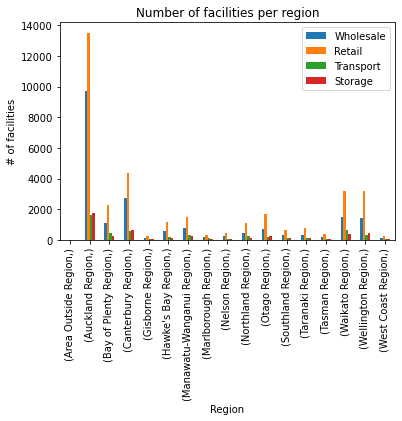

In [177]:
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/
Dat=groupA.loc[(groupA['Year']==2020) &(groupA['ParentArea']=="NewZealand"),]
plotdata = pd.DataFrame({
    "Wholesale":list(Dat['F_GeogUnits']),
    "Retail":list(Dat['G_GeogUnits']),
    "Transport":list(Dat['Trans_GeogUnits']),
    "Storage":list(Dat['Storage_GeogUnits'])
    }, 
    index=[list(Dat['Area'])]
)
plt.figure(figsize=(3, 3))
plotdata.plot(kind="bar")
plt.title("Number of facilities per region")
plt.xlabel("Region")
plt.ylabel("# of facilities")
plt.show()

#f.savefig("foo.pdf", bbox_inches='tight')

What percentage of total facilities is in each region?

In [328]:
# pie charts
def dataForPie(year):
    Dat=groupA.loc[(groupA['Year']==year) &(groupA['ParentArea']=="NewZealand"),]
    Dat['Distrib_GeogUnits']=Dat[['Trans_GeogUnits','Storage_GeogUnits']].sum(axis="columns")
    Dat['SellSide_GeogUnits']=Dat[['F_GeogUnits','G_GeogUnits']].sum(axis="columns")

    rest=['Area Outside Region','Gisborne Region','Marlborough Region','Nelson Region','Southland Region',
         'Tasman Region',"Hawke's Bay Region",'Northland Region','Taranaki Region','West Coast Region']
    important=['Auckland Region','Bay of Plenty Region','Canterbury Region','Manawatu-Wanganui Region',
                 'Otago Region','Waikato Region','Wellington Region',"Rest of NZ"]
    restOfNZ=Dat.loc[Dat['Area'].isin(rest),]
    restOfNZ=restOfNZ.sum(axis=0)
    new_row={'Area':"Rest of NZ", 'TotInd_GeogUnits':int(restOfNZ['TotInd_GeogUnits']), 
         'TotInd_EmpCo':np.nan,'F_GeogUnits':np.nan, 'F_EmpCo':np.nan,'G_GeogUnits':np.nan, 
         'G_EmpCo':np.nan, 'ParentArea':"", 'Year':year, 'Trans_GeogUnits':np.nan,
       'Trans_EmpCo':np.nan, 'Storage_GeogUnits':np.nan, 'Storage_EmpCo':np.nan, 'landArea':np.nan,
       'TotInd_Dens':np.nan, 'F_Dens':np.nan, 'G_Dens':np.nan, 'Trans_Dens':np.nan, 'Stor_Dens':np.nan,
       'TotInd_EmpDensFac':np.nan, 'F_EmpDensFac':np.nan, 'G_EmpDensFac':np.nan, 'Trans_EmpDensFac':np.nan,
       'Stor_EmpDensFac':np.nan, 'Distrib_GeogUnits':int(restOfNZ['Distrib_GeogUnits']), 'SellSide_GeogUnits':int(restOfNZ['SellSide_GeogUnits'])}
    Dat=Dat.append(new_row,ignore_index=True)
    Dat=Dat[Dat['Area'].isin(important)]
    return(Dat)


<ipython-input-328-caefc3f4ae4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['Distrib_GeogUnits']=Dat[['Trans_GeogUnits','Storage_GeogUnits']].sum(axis="columns")
<ipython-input-328-caefc3f4ae4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['SellSide_GeogUnits']=Dat[['F_GeogUnits','G_GeogUnits']].sum(axis="columns")


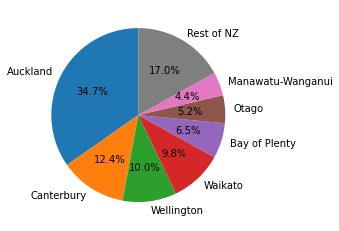

In [329]:
# Tot Industry
plotDat=dataForPie(2020)
plotDat=plotDat[['Area','TotInd_GeogUnits']]
plotDat=plotDat.sort_values(by='TotInd_GeogUnits',ascending=False)
plotDat = plotDat.reindex([1, 3, 15, 14, 2, 10, 6,17])

y = np.array(plotDat['TotInd_GeogUnits'])
#mylabels = list(plotDat['Area'])
mylabels = ['Auckland','Canterbury','Wellington','Waikato','Bay of Plenty','Otago','Manawatu-Wanganui','Rest of NZ']

plt.pie(y, labels = mylabels, startangle=90, autopct='%1.1f%%')
#plt.show()
plt.savefig("../../manuscript_NZ/graphics/PieTot_2020.pdf") 

<ipython-input-328-caefc3f4ae4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['Distrib_GeogUnits']=Dat[['Trans_GeogUnits','Storage_GeogUnits']].sum(axis="columns")
<ipython-input-328-caefc3f4ae4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['SellSide_GeogUnits']=Dat[['F_GeogUnits','G_GeogUnits']].sum(axis="columns")


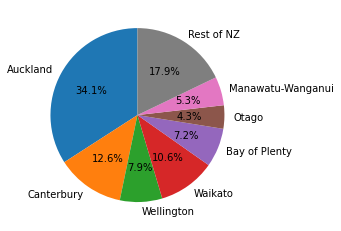

In [330]:
# Distrib Units
plotDat=dataForPie(2020)
plotDat=plotDat[['Area','Distrib_GeogUnits']]
plotDat=plotDat.sort_values(by='Distrib_GeogUnits',ascending=False)
plotDat = plotDat.reindex([1, 3, 15, 14, 2, 10, 6,17])
y = np.array(plotDat['Distrib_GeogUnits'])
#mylabels = list(plotDat['Area'])
mylabels = ['Auckland','Canterbury','Wellington','Waikato','Bay of Plenty','Otago','Manawatu-Wanganui','Rest of NZ']

plt.pie(y, labels = mylabels, startangle=90, autopct='%1.1f%%')
#plt.show()
plt.savefig("../../manuscript_NZ/graphics/PieDistr_2020.pdf") 

<ipython-input-328-caefc3f4ae4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['Distrib_GeogUnits']=Dat[['Trans_GeogUnits','Storage_GeogUnits']].sum(axis="columns")
<ipython-input-328-caefc3f4ae4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['SellSide_GeogUnits']=Dat[['F_GeogUnits','G_GeogUnits']].sum(axis="columns")


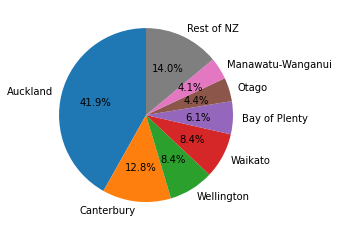

In [331]:
# SellSide Units
plotDat=dataForPie(2020)
plotDat=plotDat[['Area','SellSide_GeogUnits']]
plotDat=plotDat.sort_values(by='SellSide_GeogUnits',ascending=False)
plotDat = plotDat.reindex([1, 3, 15, 14, 2, 10, 6,17])
y = np.array(plotDat['SellSide_GeogUnits'])
#mylabels = list(plotDat['Area'])
mylabels = ['Auckland','Canterbury','Wellington','Waikato','Bay of Plenty','Otago','Manawatu-Wanganui','Rest of NZ']

plt.pie(y, labels = mylabels, startangle=90, autopct='%1.1f%%')
#plt.show()
plt.savefig("../../manuscript_NZ/graphics/PieSell_2020.pdf") 

In [337]:
dat2000=dataForPie(2000)
dat2000=dat2000[['Area','TotInd_GeogUnits','Distrib_GeogUnits','SellSide_GeogUnits']]
new_row={'Area':'Total','TotInd_GeogUnits':sum(dat2000.TotInd_GeogUnits),'Distrib_GeogUnits':sum(dat2000.Distrib_GeogUnits),'SellSide_GeogUnits':sum(dat2000.SellSide_GeogUnits)}
dat2000=dat2000.append(new_row,ignore_index=True)
dat2000['Perc_totInd']=dat2000['TotInd_GeogUnits']/dat2000.iloc[8,1]
dat2000['Perc_Distrib']=dat2000['Distrib_GeogUnits']/dat2000.iloc[8,2]
dat2000['Perc_SellSide']=dat2000['SellSide_GeogUnits']/dat2000.iloc[8,3]

dat2005=dataForPie(2005)
dat2005=dat2005[['Area','TotInd_GeogUnits','Distrib_GeogUnits','SellSide_GeogUnits']]
new_row={'Area':'Total','TotInd_GeogUnits':sum(dat2005.TotInd_GeogUnits),'Distrib_GeogUnits':sum(dat2005.Distrib_GeogUnits),'SellSide_GeogUnits':sum(dat2005.SellSide_GeogUnits)}
dat2005=dat2005.append(new_row,ignore_index=True)
dat2005['Perc_totInd']=dat2005['TotInd_GeogUnits']/dat2005.iloc[8,1]
dat2005['Perc_Distrib']=dat2005['Distrib_GeogUnits']/dat2005.iloc[8,2]
dat2005['Perc_SellSide']=dat2005['SellSide_GeogUnits']/dat2005.iloc[8,3]

dat2010=dataForPie(2010)
dat2010=dat2010[['Area','TotInd_GeogUnits','Distrib_GeogUnits','SellSide_GeogUnits']]
new_row={'Area':'Total','TotInd_GeogUnits':sum(dat2010.TotInd_GeogUnits),'Distrib_GeogUnits':sum(dat2010.Distrib_GeogUnits),'SellSide_GeogUnits':sum(dat2010.SellSide_GeogUnits)}
dat2010=dat2010.append(new_row,ignore_index=True)
dat2010['Perc_totInd']=dat2010['TotInd_GeogUnits']/dat2010.iloc[8,1]
dat2010['Perc_Distrib']=dat2010['Distrib_GeogUnits']/dat2010.iloc[8,2]
dat2010['Perc_SellSide']=dat2010['SellSide_GeogUnits']/dat2010.iloc[8,3]

dat2015=dataForPie(2015)
dat2015=dat2015[['Area','TotInd_GeogUnits','Distrib_GeogUnits','SellSide_GeogUnits']]
new_row={'Area':'Total','TotInd_GeogUnits':sum(dat2015.TotInd_GeogUnits),'Distrib_GeogUnits':sum(dat2015.Distrib_GeogUnits),'SellSide_GeogUnits':sum(dat2015.SellSide_GeogUnits)}
dat2015=dat2015.append(new_row,ignore_index=True)
dat2015['Perc_totInd']=dat2015['TotInd_GeogUnits']/dat2015.iloc[8,1]
dat2015['Perc_Distrib']=dat2015['Distrib_GeogUnits']/dat2015.iloc[8,2]
dat2015['Perc_SellSide']=dat2015['SellSide_GeogUnits']/dat2015.iloc[8,3]

dat2020=dataForPie(2020)
dat2020=dat2020[['Area','TotInd_GeogUnits','Distrib_GeogUnits','SellSide_GeogUnits']]
new_row={'Area':'Total','TotInd_GeogUnits':sum(dat2020.TotInd_GeogUnits),'Distrib_GeogUnits':sum(dat2020.Distrib_GeogUnits),'SellSide_GeogUnits':sum(dat2020.SellSide_GeogUnits)}
dat2020=dat2020.append(new_row,ignore_index=True)
dat2020['Perc_totInd']=dat2020['TotInd_GeogUnits']/dat2020.iloc[8,1]
dat2020['Perc_Distrib']=dat2020['Distrib_GeogUnits']/dat2020.iloc[8,2]
dat2020['Perc_SellSide']=dat2020['SellSide_GeogUnits']/dat2020.iloc[8,3]

<ipython-input-328-caefc3f4ae4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['Distrib_GeogUnits']=Dat[['Trans_GeogUnits','Storage_GeogUnits']].sum(axis="columns")
<ipython-input-328-caefc3f4ae4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dat['SellSide_GeogUnits']=Dat[['F_GeogUnits','G_GeogUnits']].sum(axis="columns")
<ipython-input-328-caefc3f4ae4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [377]:
dat2020.sort_values('Distrib_GeogUnits',ascending=False)

,Area,TotInd_GeogUnits,Distrib_GeogUnits,SellSide_GeogUnits,Perc_totInd,Perc_Distrib,Perc_SellSide
8,Total,593595.0,9807.0,55482.0,1.000000,1.000000,1.000000
0,Auckland Region,206058.0,3345.0,23226.0,0.347136,0.341083,0.418622
7,Rest of NZ,100665.0,1752.0,7740.0,0.169585,0.178648,0.139505
2,Canterbury Region,73548.0,1239.0,7086.0,0.123903,0.126338,0.127717
5,Waikato Region,58353.0,1044.0,4686.0,0.098304,0.106455,0.084460
6,Wellington Region,59457.0,771.0,4638.0,0.100164,0.078617,0.083595
1,Bay of Plenty Region,38862.0,708.0,3402.0,0.065469,0.072193,0.061317
3,Manawatu-Wanganui Region,25983.0,522.0,2268.0,0.043772,0.053227,0.040878
4,Otago Region,30669.0,426.0,2436.0,0.051667,0.043438,0.043906


How do these percentage breakdowns compare to regional GDP and population?

In [432]:
#read in Group E files for population

groupE=readFiles("../CompleteSet_GroupE.csv")
groupE2001=readFiles("../CompleteSet_2001_GroupE.csv")

#Filter to only regions
groupE=groupE.loc[groupE['ParentArea']=="NewZealand",]
areas=groupE['Area']
groupE2001=groupE2001.loc[groupE2001['ParentArea']=="NewZealand",]
groupE2001['Area']=list(areas.unique())

d={'Area':groupE2001['Area'],'contrib2001':np.nan,'contrib2006':np.nan,'contrib2013':np.nan,'contrib2018':np.nan}
contrib=pd.DataFrame(data=d)

In [417]:
groupE2001

,Area,TotUsuallyResident,European,Maori,Pacific,Asia,Other,TotalSpec1orMore,ParentArea,Year
1,Area Outside Region,726,468.0,390.0,12.0,3.0,0.0,666.0,NewZealand,2001
21,Auckland Region,1158891,754749.0,127626.0,154680.0,151602.0,13662.0,1101594.0,NewZealand,2001
393,Bay of Plenty Region,239412,178623.0,63654.0,5463.0,5202.0,495.0,228300.0,NewZealand,2001
517,Canterbury Region,481431,430125.0,31635.0,8622.0,19428.0,2364.0,468570.0,NewZealand,2001
742,Gisborne Region,43974,26466.0,19362.0,1140.0,621.0,75.0,41922.0,NewZealand,2001
768,Hawke's Bay Region,142950,110049.0,32085.0,4710.0,2937.0,312.0,137616.0,NewZealand,2001
851,Manawatu-Wanganui Region,220089,180921.0,39267.0,5031.0,6564.0,822.0,212487.0,NewZealand,2001
982,Marlborough Region,39561,36141.0,3894.0,405.0,387.0,72.0,38355.0,NewZealand,2001
1004,Nelson Region,41568,37611.0,3219.0,591.0,861.0,96.0,40206.0,NewZealand,2001
1036,Northland Region,140133,99576.0,40734.0,2943.0,1998.0,318.0,128937.0,NewZealand,2001


In [433]:
contrib['contrib2001']=np.nan
contrib['contrib2006']=np.nan
contrib['contrib2013']=np.nan
contrib['contrib2018']=np.nan
total_2001=sum(groupE2001.TotUsuallyResident)
total_2006=sum(groupE.loc[groupE['Year']==2006,'TotPeople'])
total_2013=sum(groupE.loc[groupE['Year']==2013,'TotPeople'])
total_2018=sum(groupE.loc[groupE['Year']==2018,'TotPeople'])

for i in range(len(contrib)):
    contrib.iloc[i,1]=groupE2001.loc[groupE2001['Area']==contrib.iloc[i,0],'TotUsuallyResident']/total_2001 #2001
    contrib.iloc[i,2]=groupE.loc[(groupE['Area']==contrib.iloc[i,0]) & (groupE['Year']==2006),'TotPeople']/total_2006 #2006
    contrib.iloc[i,3]=groupE.loc[(groupE['Area']==contrib.iloc[i,0]) & (groupE['Year']==2013),'TotPeople']/total_2013 #2013
    contrib.iloc[i,4]=groupE.loc[(groupE['Area']==contrib.iloc[i,0]) & (groupE['Year']==2018),'TotPeople']/total_2018 #2018
 




In [434]:
important=['Auckland Region','Bay of Plenty Region','Canterbury Region','Manawatu-Wanganui Region',
                 'Otago Region','Waikato Region','Wellington Region',"Rest of NZ"]
rest=['Area Outside Region','Gisborne Region','Marlborough Region','Nelson Region','Southland Region',
         'Tasman Region',"Hawke's Bay Region",'Northland Region','Taranaki Region','West Coast Region']
restOfNZ=contrib.loc[contrib['Area'].isin(rest),]
restOfNZ=restOfNZ.sum(axis=0)
new_row={'Area':"Rest of NZ", 'contrib2001':restOfNZ['contrib2001'],'contrib2006':restOfNZ['contrib2006'],'contrib2013':restOfNZ['contrib2013'],'contrib2018':restOfNZ['contrib2018']}
contrib=contrib.append(new_row,ignore_index=True)
contrib=contrib[contrib['Area'].isin(important)]


In [438]:
contrib.sort_values(by='contrib2001',ascending=False)

,Area,contrib2001,contrib2006,contrib2013,contrib2018
1,Auckland Region,0.310089,0.323975,0.333694,0.334426
17,Rest of NZ,0.180460,0.173235,0.169547,0.168273
3,Canterbury Region,0.128818,0.129553,0.127164,0.127601
15,Wellington Region,0.113389,0.111461,0.111105,0.107838
14,Waikato Region,0.095718,0.094545,0.095152,0.097495
2,Bay of Plenty Region,0.064060,0.063897,0.063117,0.065642
6,Manawatu-Wanganui Region,0.058890,0.055219,0.052492,0.050811
10,Otago Region,0.048576,0.048114,0.047729,0.047914


Let's consider the growth dynamics. Growth rates and birth/death

In [353]:
print((dat2020.iloc[8,1]-dat2000.iloc[8,1])/dat2000.iloc[8,1])
print((dat2020.iloc[8,2]-dat2000.iloc[8,2])/dat2000.iloc[8,2])
print((dat2020.iloc[8,3]-dat2000.iloc[8,3])/dat2000.iloc[8,3])

print((dat2020.iloc[8,1]-dat2020.iloc[8,2]-dat2020.iloc[8,3])/dat2020.iloc[8,2])
print(dat2020.iloc[8,3]/dat2020.iloc[8,2])



0.46152027950333496
0.0015318627450980392
0.09978591817316841
53.870296726827775
5.657387580299786


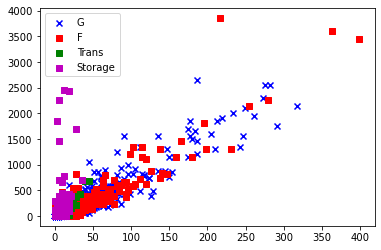

In [440]:
Dat=groupA.loc[(groupA['Year']==2000) &(groupA['ParentArea']!="NewZealand"),]
#plt.scatter(Dat['TotInd_GeogUnits'],Dat['TotInd_EmpCo'], c='k', marker='x', label='Tot')
plt.scatter(Dat['G_GeogUnits'],Dat['G_EmpCo'], c='b', marker='x', label='G')
plt.scatter(Dat['F_GeogUnits'], Dat['F_EmpCo'], c='r', marker='s', label='F')
plt.scatter(Dat['Trans_GeogUnits'], Dat['Trans_EmpCo'], c='g', marker='s', label='Trans')
plt.scatter(Dat['Storage_GeogUnits'], Dat['Storage_EmpCo'], c='m', marker='s', label='Storage')
plt.legend(loc='upper left')
plt.show()

In [192]:
Dat.sort_values(by="Stor_Dens",axis=0,ascending=False)


,Area,TotInd_GeogUnits,TotInd_EmpCo,F_GeogUnits,F_EmpCo,G_GeogUnits,G_EmpCo,ParentArea,Year,Trans_GeogUnits,Trans_EmpCo,Storage_GeogUnits,Storage_EmpCo,landArea,TotInd_Dens,F_Dens,G_Dens,Trans_Dens,Stor_Dens,TotInd_EmpDensFac,F_EmpDensFac,G_EmpDensFac,Trans_EmpDensFac,Stor_EmpDensFac,TotInd_5yrGrowth,F_5yrGrowth,G_5yrGrowth,Trans_5yrGrowth,Stor_5yrGrowth
101,Area Outside Region,189.0,390.0,3.0,15.0,0.0,15.0,NewZealand,2020,0.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2.063492,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11407,Auckland Region,206058.0,807400.0,9708.0,59300.0,13518.0,75200.0,NewZealand,2020,1617.0,9730.0,1728.0,8100.0,0.0,NaN,NaN,NaN,NaN,NaN,3.918314,6.108364,5.562953,6.017316,4.687500,NaN,NaN,NaN,NaN,NaN
14892,Bay of Plenty Region,38862.0,137600.0,1098.0,5300.0,2304.0,14500.0,NewZealand,2020,435.0,2356.0,273.0,960.0,0.0,NaN,NaN,NaN,NaN,NaN,3.540734,4.826958,6.293403,5.416092,3.516484,NaN,NaN,NaN,NaN,NaN
21318,Canterbury Region,73548.0,307500.0,2700.0,15800.0,4386.0,31300.0,NewZealand,2020,600.0,4860.0,639.0,2320.0,0.0,NaN,NaN,NaN,NaN,NaN,4.180943,5.851852,7.136343,8.100000,3.630673,NaN,NaN,NaN,NaN,NaN
22212,Gisborne Region,5175.0,22300.0,129.0,620.0,276.0,1800.0,NewZealand,2020,72.0,400.0,39.0,73.0,0.0,NaN,NaN,NaN,NaN,NaN,4.309179,4.806202,6.521739,5.555556,1.871795,NaN,NaN,NaN,NaN,NaN
24041,Hawke's Bay Region,19548.0,82400.0,576.0,2600.0,1134.0,7100.0,NewZealand,2020,210.0,1171.0,141.0,660.0,0.0,NaN,NaN,NaN,NaN,NaN,4.215265,4.513889,6.261023,5.576190,4.680851,NaN,NaN,NaN,NaN,NaN
26951,Manawatu-Wanganui Region,25983.0,107000.0,756.0,5300.0,1512.0,10200.0,NewZealand,2020,291.0,1800.0,231.0,860.0,0.0,NaN,NaN,NaN,NaN,NaN,4.118077,7.010582,6.746032,6.185567,3.722944,NaN,NaN,NaN,NaN,NaN
27612,Marlborough Region,7113.0,24700.0,165.0,570.0,309.0,2500.0,NewZealand,2020,87.0,475.0,51.0,95.0,0.0,NaN,NaN,NaN,NaN,NaN,3.472515,3.454545,8.090615,5.459770,1.862745,NaN,NaN,NaN,NaN,NaN
28218,Nelson Region,6342.0,27700.0,237.0,1250.0,429.0,3000.0,NewZealand,2020,54.0,250.0,69.0,215.0,0.0,NaN,NaN,NaN,NaN,NaN,4.367707,5.274262,6.993007,4.629630,3.115942,NaN,NaN,NaN,NaN,NaN
30327,Northland Region,21636.0,63900.0,450.0,1900.0,1083.0,6900.0,NewZealand,2020,276.0,1015.0,141.0,255.0,0.0,NaN,NaN,NaN,NaN,NaN,2.953411,4.222222,6.371191,3.677536,1.808511,NaN,NaN,NaN,NaN,NaN


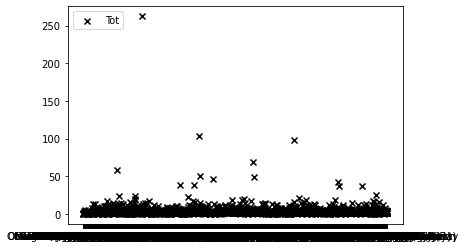

In [150]:
Dat=groupA.loc[(groupA['Year']==2000) &(groupA['ParentArea']!="NewZealand"),]
plt.scatter(Dat['Area'],Dat['TotInd_EmpDensFac'], c='k', marker='x', label='Tot')
plt.legend(loc='upper left')
plt.show()

(0.0, 100.0)

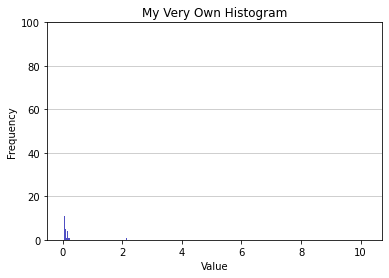

In [158]:
plt.hist(x=Dat['Stor_EmpDensFac'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.ylim(ymax=100)

Text(0.5, 1.0, 'My Very Own Histogram')

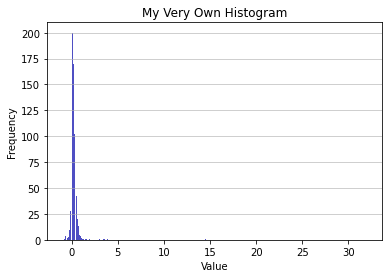

In [120]:
#https://realpython.com/python-histograms/#visualizing-histograms-with-matplotlib-and-pandas

n, bins, patches = plt.hist(x=growth2000_2005['TotInd_GeogUnits'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
#maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [109]:
(int(record_2['TotInd_GeogUnits'])-int(record_1['TotInd_GeogUnits']))/int(record_1['TotInd_GeogUnits'])

-0.014925373134328358

In [108]:
record_1['TotInd_GeogUnits']

1    201.0
Name: TotInd_GeogUnits, dtype: float64

In [204]:
1821+1509

3330